In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [4]:
!pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)


In [ ]:
import cv2
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# ==============================
# 1. Função para extrair frames (1 a cada N)
# ==============================
def extract_frames(video_path, frames_dir, frame_step=5):
    os.makedirs(frames_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    while True:
        success, frame = cap.read()
        if not success:
            break

        if frame_count % frame_step == 0:
            frame_path = os.path.join(frames_dir, f"frame_{saved_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    # print(f"Extraídos {saved_count} frames (de {frame_count} totais) para {frames_dir}")


# ==============================
# 2. Dataset personalizado
# ==============================
class VideoFramesDataset(Dataset):
    def __init__(self, frames_dir, transform=None):
        # Procura recursivamente por todos os frames .jpg
        self.frame_files = sorted([
            os.path.join(root, f)
            for root, _, files in os.walk(frames_dir)
            for f in files if f.lower().endswith(".jpg")
        ])
        self.transform = transform

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        img_path = self.frame_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


# ==============================
# 3. Processar todos os vídeos de uma pasta
# ==============================
def process_videos(videos_folder, frames_root="./frames", frame_step=5):
    # Verificação de segurança adicionada
    if not os.path.exists(videos_folder):
        print(f"ERRO: Pasta de vídeos não encontrada: {videos_folder}")
        return

    print(f"Processando vídeos em: {videos_folder}...")
    
    for video_file in os.listdir(videos_folder):
        if video_file.lower().endswith((".mp4", ".avi", ".mov")):
            video_path = os.path.join(videos_folder, video_file)
            # Cria subpasta para cada vídeo
            video_name = os.path.splitext(video_file)[0]
            frames_dir = os.path.join(frames_root, video_name)
            # Extrai frames se a pasta estiver vazia
            if not os.path.exists(frames_dir) or len(os.listdir(frames_dir)) == 0:
                extract_frames(video_path, frames_dir, frame_step=frame_step)
    
    print("Processamento de vídeos finalizado.")


# ==============================
# 4. Exemplo de uso
# ==============================
if __name__ == "__main__":
    current_notebook_dir = os.getcwd()
    # Aponta para dataset/scenario1/videos
    video_folder_relative = os.path.join(current_notebook_dir, '..', '..', 'dataset', 'scenario1', 'videos')
    VIDEO_FOLDER = os.path.abspath(video_folder_relative)
    
    # Salva frames em dataset/scenario1/frames (para não poluir a pasta do modelo)
    frames_folder_relative = os.path.join(current_notebook_dir, '..', '..', 'dataset', 'scenario1', 'frames')
    FRAMES_ROOT = os.path.abspath(frames_folder_relative)
    
    frame_step = 5
    process_videos(VIDEO_FOLDER, FRAMES_ROOT, frame_step)

    # Transform igual à do MNIST (Ajustado para 64x64 para compatibilidade VAE)
    transform = transforms.Compose([
        transforms.Resize((64, 64)), # Alterado de 100 para 64 (potência de 2)
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    # Cria dataset com todos os frames extraídos
    full_dataset = VideoFramesDataset(FRAMES_ROOT, transform=transform)

    # Verificação para evitar erro no random_split se não houver imagens
    if len(full_dataset) > 0:
        # Divide entre treino (80%) e teste (20%)
        total_size = len(full_dataset)
        train_size = int(0.8 * total_size)
        test_size = total_size - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        # Cria os dataloaders
        batch_size = 140
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define o device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"train_dataset: {len(train_dataset)} frames")
        print(f"test_dataset: {len(test_dataset)} frames")
        print(f"device: {device}")
        
        # Teste rápido do shape
        try:
            batch_example = next(iter(train_loader))
            print(f"Shape do Batch: {batch_example.shape}")
        except Exception as e:
            print(f"Aviso: Não foi possível carregar um batch de exemplo. {e}")
            
    else:
        print("Nenhum frame encontrado. Verifique se os vídeos foram gerados e o caminho está correto.")
        print(f"Caminho procurado: {FRAMES_ROOT}")


✅ Extraídos 126 frames (de 630 totais) para ./frames/random_input_20251005161831_138_auto_05-10-2025_16-18-40
✅ Extraídos 140 frames (de 698 totais) para ./frames/random_input_20251005161831_193_auto_05-10-2025_16-21-14
✅ Extraídos 115 frames (de 573 totais) para ./frames/random_input_20251005161830_05_auto_05-10-2025_16-24-13
✅ Extraídos 113 frames (de 561 totais) para ./frames/random_input_20251005161831_130_auto_05-10-2025_16-22-54
✅ Extraídos 134 frames (de 666 totais) para ./frames/random_input_20251005161830_46_auto_05-10-2025_16-20-03
✅ Extraídos 104 frames (de 517 totais) para ./frames/random_input_20251005161831_191_auto_05-10-2025_16-20-42
✅ Extraídos 128 frames (de 638 totais) para ./frames/random_input_20251005161831_123_auto_05-10-2025_16-22-43
✅ Extraídos 114 frames (de 567 totais) para ./frames/random_input_20251005161831_101_auto_05-10-2025_16-22-56
✅ Extraídos 134 frames (de 666 totais) para ./frames/random_input_20251005161830_07_auto_05-10-2025_16-22-34
✅ Extraídos 1

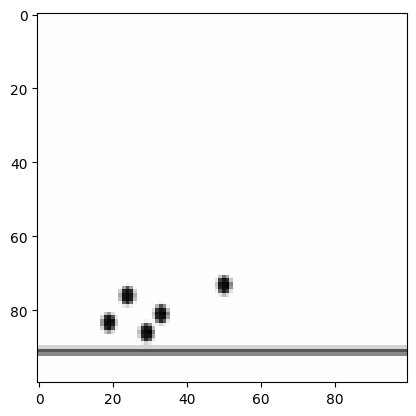

In [67]:
import matplotlib.pyplot as plt

# batch de exemplo
batch = next(iter(train_loader))
images = batch  # se seu dataloader retorna (inputs, targets)

# pegar a primeira imagem
img = images[0]  # shape [1, 28, 28]

# remover o canal extra para matplotlib
img = img.squeeze()  # shape [28, 28]

plt.imshow(img, cmap='gray')
plt.show()

In [70]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim=10000, hidden_dim=2048, latent_dim=1024):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)                     
        return mean, log_var

In [71]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim=10000, hidden_dim=2048, latent_dim=1024):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))
        
        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [72]:
class VAE(nn.Module):

    def __init__(self, input_dim=10000, hidden_dim=2048, latent_dim=1024, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var
     

In [73]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [74]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [75]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        total_samples = 0

        for batch_idx, x in enumerate(train_loader):
            # Ajuste seguro para batch final
            x = x.to(device)
            x = x.view(x.size(0), -1)  # [B, C*H*W]

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            # acumula loss multiplicando pelo tamanho real do batch
            overall_loss += loss.item() * x.size(0)
            total_samples += x.size(0)
            
            loss.backward()
            optimizer.step()

        avg_loss = overall_loss / total_samples
        print(f"\tEpoch {epoch + 1} \tAverage Loss: {avg_loss:.6f}")

    return overall_loss


In [ ]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss: 4577037646.183909
	Epoch 2 	Average Loss: 3290668.480962
	Epoch 3 	Average Loss: 4491497.183909


KeyboardInterrupt: 

In [ ]:
# Pega um batch do DataLoader
for batch in train_loader:
    print("Shape do batch:", batch.shape)
    break


In [11]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()
     

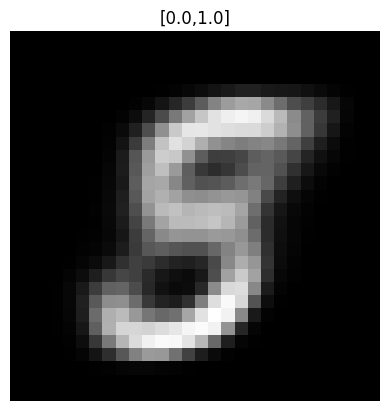

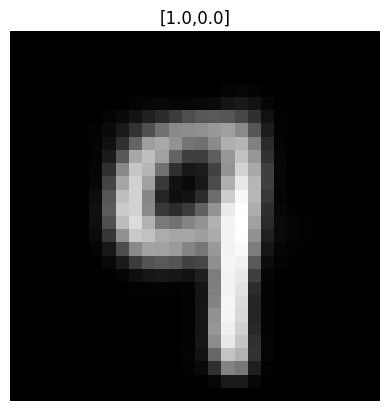

(None, None)

In [12]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [13]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
     

/tmp/ipykernel_295711/205503542.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


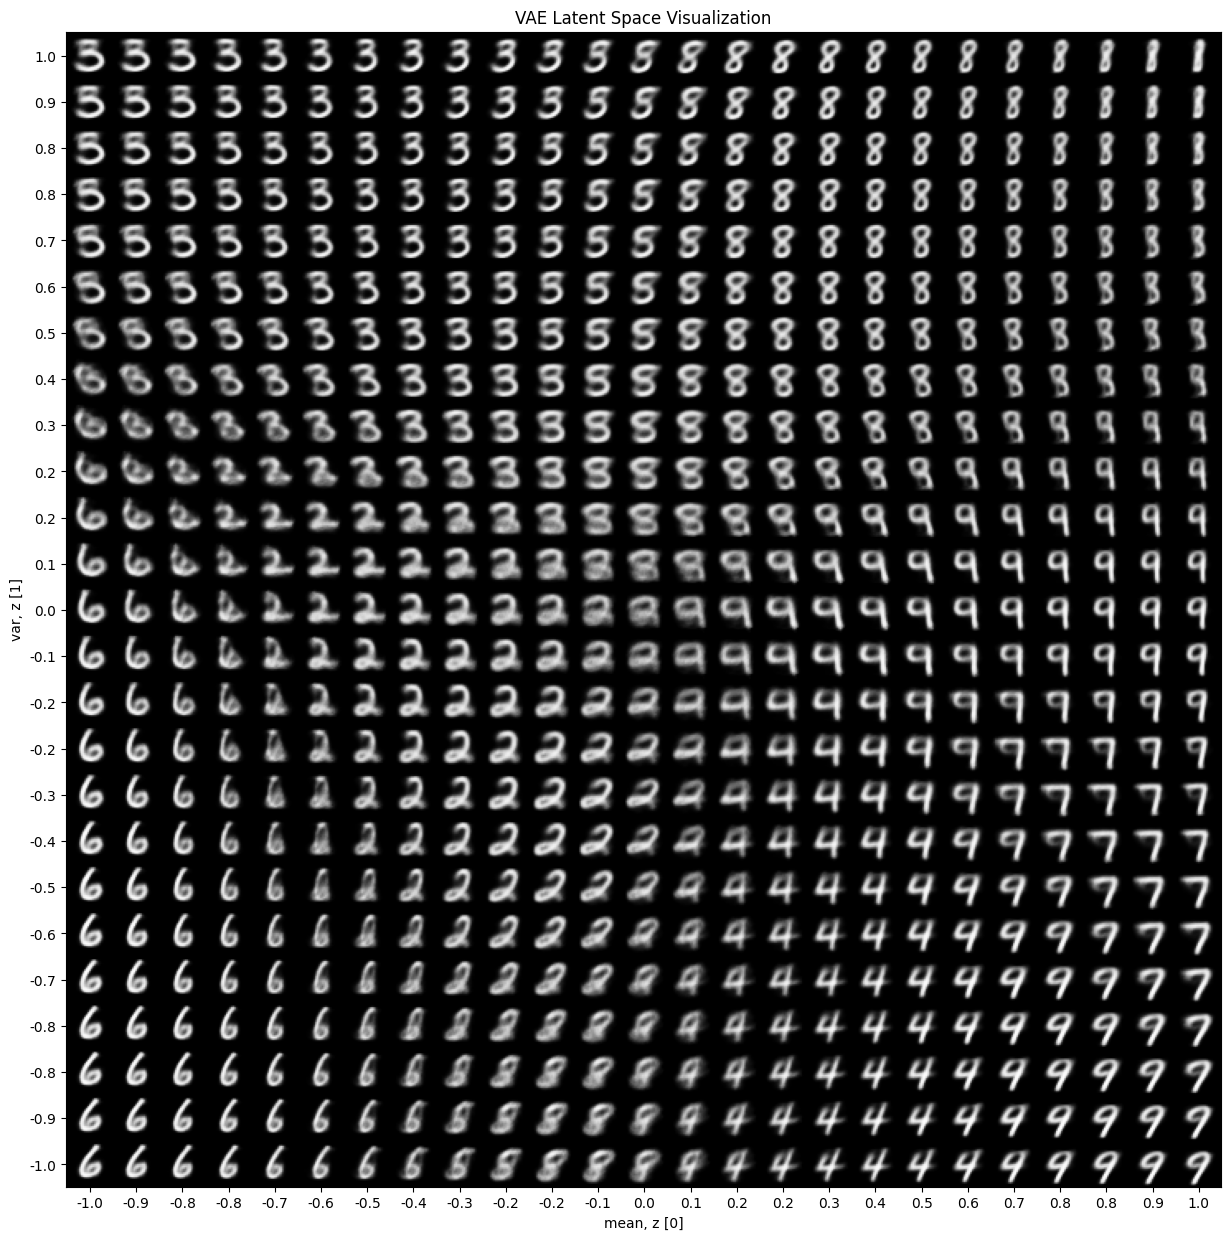

In [14]:
plot_latent_space(model, scale=1.0)

/tmp/ipykernel_295711/205503542.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


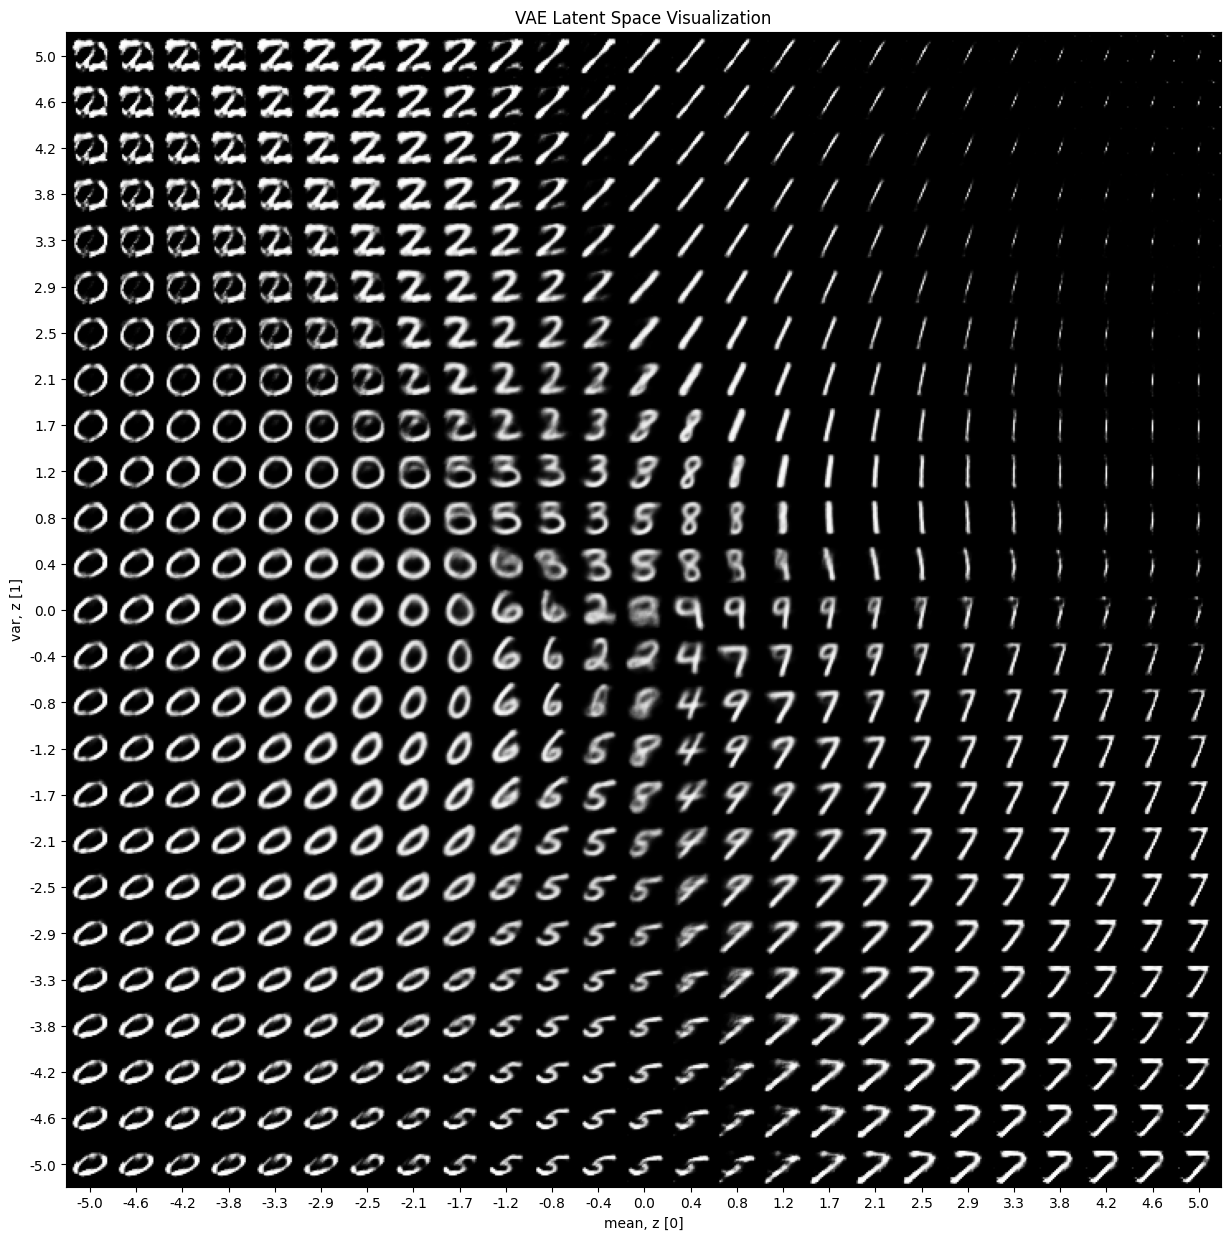

In [15]:
plot_latent_space(model, scale=5.0)